# Tutorial 6: Classification

### Lecture and Tutorial Learning Goals:

After completing this week's lecture and tutorial work, you will be able to:

* Recognize situations where a simple classifier would be appropriate for making predictions.
* Explain the k-nearest neighbour classification algorithm.
* Interpret the output of a classifier.
* Compute, by hand, the distance between points when there are two explanatory variables/predictors.
* Describe what a training data set is and how it is used in classification.
* In a dataset with two explanatory variables/predictors, perform k-nearest neighbour classification in R using `tidymodels` to predict the class of a single new observation.

In [1]:
### Run this cell before continuing. 
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
source('tests_tutorial_06.R')
source("cleanup_tutorial_06.R")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

**Question 0.1** Multiple Choice: 
<br> {points: 1}

Before applying k-nearest neighbour to a classification task, we need to scale the data. What is the purpose of this step?

A. To help speed up the knn algorithm. 

B. To convert all data observations to numeric values. 

C. To ensure all data observations will be on a comparable scale and contribute equal shares to the calculation of the distance between points.

D. None of the above. 

*Assign your answer to an object called `answer0.1`. Make sure the correct answer is an uppercase letter. Surround your answer with quotation marks (e.g. `"F"`).*

*Note: we typically **standardize** (i.e., scale **and** center) the data before doing classification. For the K-nearest neighbour algorithm specifically, centering has no effect. But it doesn't hurt, and can help with other predictive data analyses, so we will do it below.*

In [2]:
# Replace the fail() with your answer. 

# your code here
answer0.1 <- "C"

In [3]:
test_0.1()

[1] "Success!"


## 1. Fruit Data Example 

In the agricultural industry, cleaning, sorting, grading, and packaging food products are all necessary tasks in the post-harvest process. Products are classified based on appearance, size and shape, attributes which helps determine the quality of the food. Sorting can be done by humans, but it is tedious and time consuming. Automatic sorting could help save time and money. Images of the food products are captured and analysed to determine visual characteristics. 

The [dataset](https://www.kaggle.com/mjamilmoughal/k-nearest-neighbor-classifier-to-predict-fruits/notebook) contains observations of fruit described with four features 1) mass (in g) 2) width (in cm) 3) height (in cm) and 4) color score (on a scale from 0 - 1).

**Question 1.0** 
<br> {points: 1}

Load the file, `fruit_data.csv`, into your notebook. 

`mutate()` the `fruit_name` column such that it is a *factor* using the `as_factor()` function.

*Assign your data to an object called `fruit_data`.*

In [4]:
# your code here
fruit_data <- read_csv("data/fruit_data.csv") %>%
            mutate(fruit_name = as_factor(fruit_name))
fruit_data

Parsed with column specification:
cols(
  fruit_label = col_double(),
  fruit_name = col_character(),
  fruit_subtype = col_character(),
  mass = col_double(),
  width = col_double(),
  height = col_double(),
  color_score = col_double()
)



fruit_label,fruit_name,fruit_subtype,mass,width,height,color_score
<dbl>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,apple,granny_smith,192,8.4,7.3,0.55
1,apple,granny_smith,180,8.0,6.8,0.59
1,apple,granny_smith,176,7.4,7.2,0.60
⋮,⋮,⋮,⋮,⋮,⋮,⋮
4,lemon,unknown,116,5.9,8.1,0.73
4,lemon,unknown,152,6.5,8.5,0.72
4,lemon,unknown,118,6.1,8.1,0.70


In [5]:
test_1.0()

[1] "Success!"


Let's take a look at the first few observations in the fruit dataset. Run the cell below.

In [6]:
# Run this cell. 
fruit_data

fruit_label,fruit_name,fruit_subtype,mass,width,height,color_score
<dbl>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,apple,granny_smith,192,8.4,7.3,0.55
1,apple,granny_smith,180,8.0,6.8,0.59
1,apple,granny_smith,176,7.4,7.2,0.60
⋮,⋮,⋮,⋮,⋮,⋮,⋮
4,lemon,unknown,116,5.9,8.1,0.73
4,lemon,unknown,152,6.5,8.5,0.72
4,lemon,unknown,118,6.1,8.1,0.70


**Question 1.0.1** Multiple Choice:
<br> {points: 1}

**Which of the columns should we treat as categorical variables?**

A. Fruit label, width, fruit subtype

B. Fruit name, color score, height

C. Fruit label, fruit subtype, fruit name

D. Color score, mass, width 

*Assign your answer to an object called `answer1.0.1`. Make sure the correct answer is an uppercase letter. Remember to surround your answer with quotation marks (e.g. `"E"`).*

In [7]:
# Replace the fail() with your answer. 

# your code here
answer1.0.1 <- "C"

In [8]:
test_1.0.1()

[1] "Success!"


Run the cell below, and find the nearest neighbour based on mass and width to the first observation just by looking at the scatterplot (the first observation has been circled for you).

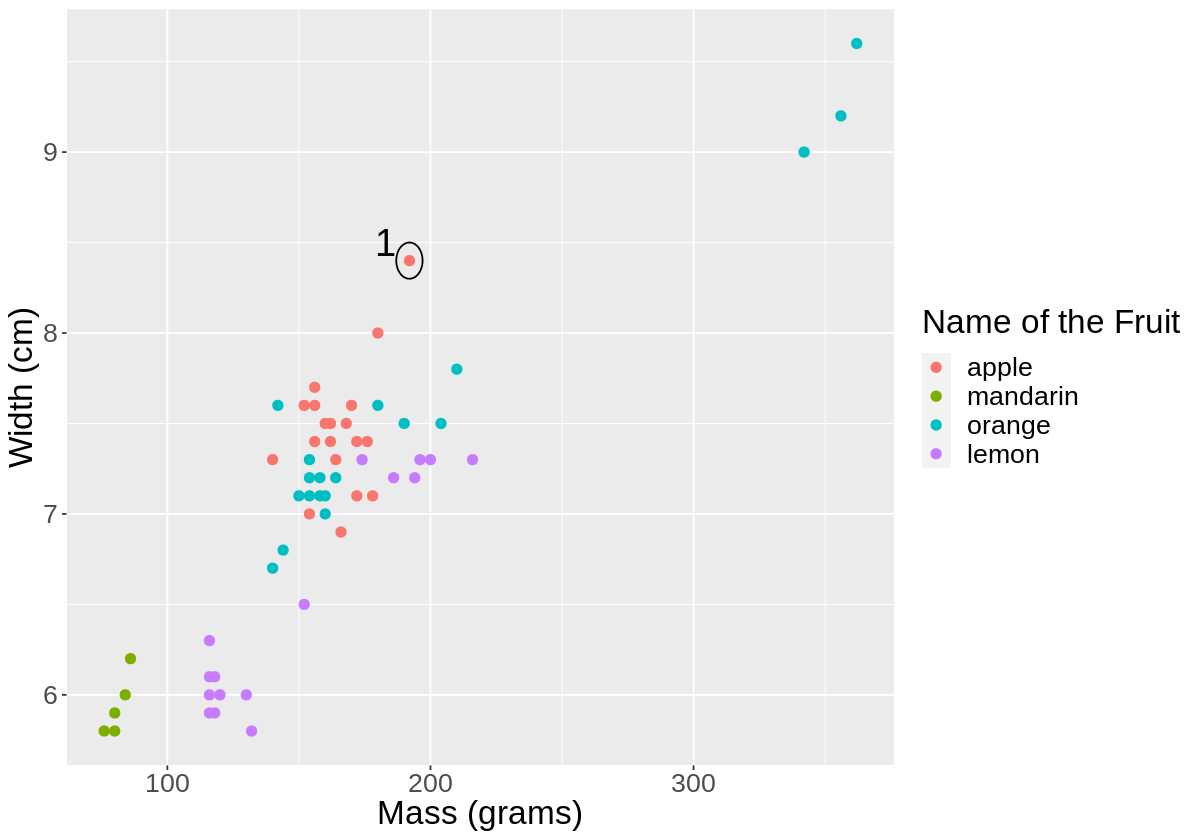

In [9]:
# Run this cell. 
options(repr.plot.width=10, repr.plot.height=7)
point1 <- c(192, 8.4)
point2 <- c(180, 8)
point44 <- c(194, 7.2)

fruit_data %>%  
    ggplot(aes(x=mass, 
               y= width, 
               colour = fruit_name)) +
        labs(x = "Mass (grams)",
             y = "Width (cm)",
            colour = 'Name of the Fruit') +
        geom_point(size = 2.5) +
        annotate("path", 
                 x=point1[1] + 5*cos(seq(0,2*pi,length.out=100)),
                 y=point1[2] + 0.1*sin(seq(0,2*pi,length.out=100))) +
        annotate("text", x = 183, y =  8.5, label = "1", size = 8) + 
        theme(text = element_text(size = 20))

**Question 1.1** Multiple Choice: 
<br> {points: 1}

Based on the graph generated, what is the `fruit_name` of the closest data point to the one circled?

A. apple

B. lemon

C. mandarin 

D. orange

*Assign your answer to an object called `answer1.1`. Make sure the correct answer is an uppercase letter. Surround your answer with quotation marks (e.g. `"F"`).*

In [10]:
# Replace the fail() with your answer. 

# your code here
answer1.1 <- "A"

In [11]:
test_1.1()

[1] "Success!"


**Question 1.2**
<br> {points: 1}

Using mass and width, calculate the distance between the first observation and the second observation. 

We provide a scaffolding to get you started. 

*Assign your answer to an object called `fruit_dist_2`.*

In [12]:
# ... <- fruit_data %>%
#    slice(1, 2) %>% # We use slice to get the first two rows of the fruit dataset
#    select(mass, ...) %>%
#    dist()

# your code here
fruit_dist_2 <- fruit_data %>%
   slice(1, 2) %>% # We use slice to get the first two rows of the fruit dataset
   select(mass, width) %>%
   dist()
fruit_dist_2

         1
2 12.00666

In [13]:
test_1.2()

[1] "Success!"


**Question 1.3**
<br> {points: 1}

Calculate the distance between the first and the the 44th observation in the fruit dataset using the mass and width variables. 

*Assign your answer to an object called `fruit_dist_44`.*

In [14]:
# your code here
fruit_dist_44 <- fruit_data %>%
   slice(1, 44) %>% # We use slice to get the first two rows of the fruit dataset
   select(mass, width) %>%
   dist()
fruit_dist_44

         1
2 2.332381

In [15]:
test_1.3()

[1] "Success!"


Let's circle these three observations on the plot from earlier.


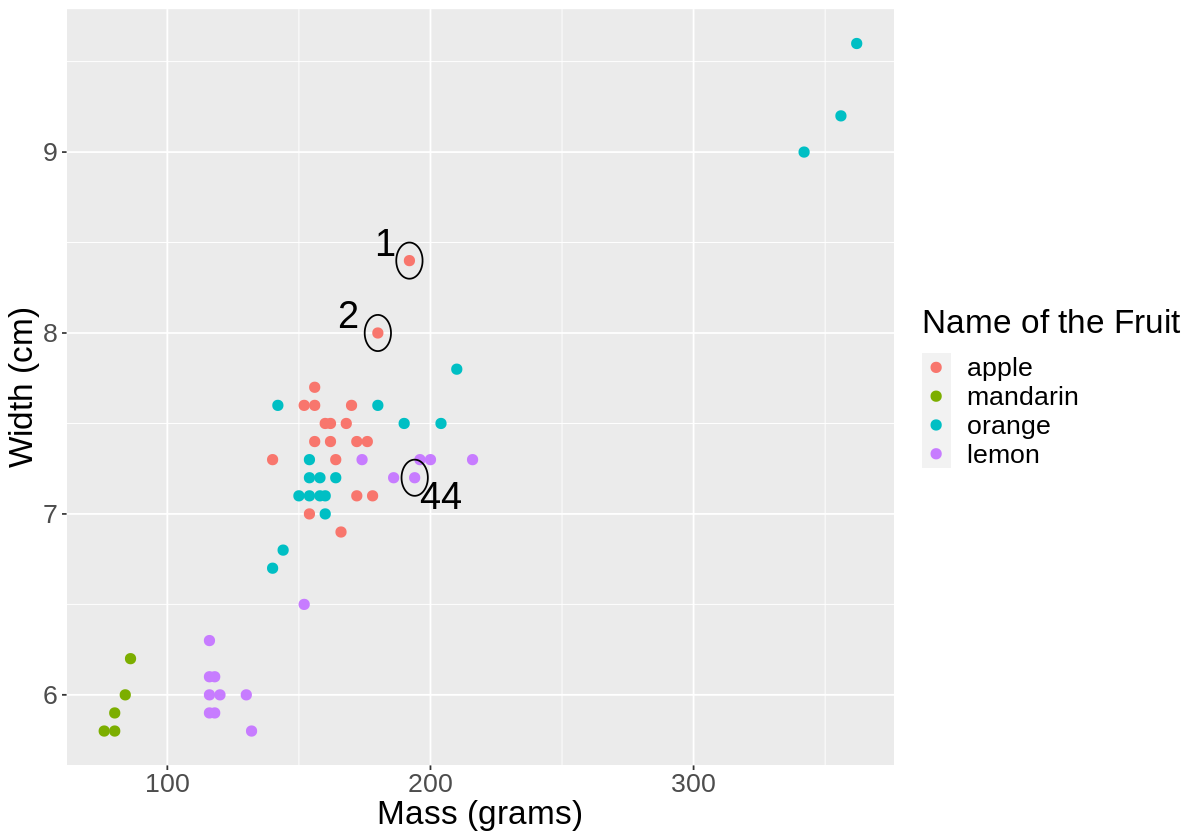

In [16]:
options(repr.plot.width = 10, repr.plot.height = 7)

# Run this cell. 
point1 <- c(192, 8.4)
point2 <- c(180, 8)
point44 <- c(194, 7.2)

fruit_data %>%
    ggplot(aes(x = mass, 
               y = width, 
               colour = fruit_name)) +
        labs(x = "Mass (grams)",
             y = "Width (cm)",
            colour = 'Name of the Fruit') +
        geom_point(size = 2.5) +
        theme(text = element_text(size = 20)) +
        annotate("path", 
                 x=point1[1] + 5*cos(seq(0,2*pi,length.out=100)),
                 y=point1[2] + 0.1*sin(seq(0,2*pi,length.out=100))) +
        annotate("text", x = 183, y =  8.5, label = "1", size = 8) +
        annotate("path",
                 x=point2[1] + 5*cos(seq(0,2*pi,length.out=100)),
                 y=point2[2] + 0.1*sin(seq(0,2*pi,length.out=100))) +
        annotate("text", x = 169, y =  8.1, label = "2", size = 8) +
        annotate("path",
                 x=point44[1] + 5*cos(seq(0,2*pi,length.out=100)),
                 y=point44[2]+0.1*sin(seq(0,2*pi,length.out=100))) +
        annotate("text", x = 204, y =  7.1, label = "44", size = 8) 

What do you notice about your answers from **Question 1.2 & 1.3** that you just calculated? Is it what you would expect given the scatter plot above? Why or why not? Discuss with your neighbour. 

*Hint: Look at where the observations are on the scatterplot in the cell above this question, and what might happen if we changed grams into kilograms to measure the mass?*


**Question 1.4** Multiple Choice:
<br> {points: 1}

The distance between the first and second observation is 12.01 and the distance between the first and 44th observation is 2.33. By the formula, observation 1 and 44 are closer, however, if we look at the scatterplot the distance of the first observation to the second observation appears closer than to the 44th observation. 

Which of the following statements is correct?

A. A difference of 12 g in mass between observation 1 and 2 is large compared to a difference of 1.2 cm in width between observation 1 and 44. Consequently, mass will drive the classification results, and width will have less of an effect. 

B. If we measured mass in kilograms, then we’d get different nearest neighbours.

C. We should standardize the data so that all variables will be on a comparable scale. 

D. All of the above. 

*Assign your answer to an object called `answer1.4`. Make sure the correct answer is an uppercase letter. Surround your answer with quotation marks (e.g. `"F"`).*

In [17]:
# Replace the fail() with your answer. 

# your code here
answer1.4 <- "D"

In [18]:
test_1.4()

[1] "Success!"


**Question 1.5**
<br> {points: 1}

Let's create a `tidymodels` recipe to *standardize* (i.e., center and scale) all of the variables in the fruit dataset. Centering will make sure that every variable has an average of 0, and scaling will make sure that every variable has standard deviation of 1. We will use the `step_scale` and `step_center` preprocessing steps in the recipe. Then `bake` the recipe so that we can examine the output.

Specify your recipe with class variable `fruit_name` and predictors `mass`, `width`, `height`, and `color_score`. 

Name the recipe `fruit_data_recipe`, and name the preprocessed data `fruit_data_scaled`.

In [19]:
# Set the seed. Don't remove this!
set.seed(9999) 

#... <- ...(fruit_name ~ .... + .... + .... + ...., data = ....) %>%
#                        ....(all_predictors()) %>%
#                        ....(all_predictors())

#... <- fruit_data_recipe %>%  
#                            ....() %>% 
#                            ....(fruit_data)


# your code here
fruit_data_recipe <- recipe(fruit_name ~ mass + width + height + color_score, data = fruit_data) %>%
                       step_scale(all_predictors()) %>%
                       step_center(all_predictors())

fruit_data_scaled <- fruit_data_recipe %>%  
                           prep() %>% # prep finalizes the recipe
                           bake(fruit_data) # bake runs the recipe, can run bake on diff dfs 
fruit_data_scaled

mass,width,height,color_score,fruit_name
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.5249358,1.5850841,-0.2889166,-2.769820,apple
0.3068287,1.0954508,-0.6562889,-2.249376,apple
0.2341263,0.3610008,-0.3623910,-2.119265,apple
⋮,⋮,⋮,⋮,⋮
-0.8564094,-1.4751241,0.2988792,-0.4278225,lemon
-0.2020880,-0.7406741,0.5927771,-0.5579334,lemon
-0.8200582,-1.2303074,0.2988792,-0.8181553,lemon


In [20]:
test_1.5()

[1] "Success!"


**Question 1.6**
<br> {points: 1}

Let's repeat **Question 1.2 and 1.3** with the scaled variables:

- calculate the distance with the scaled mass and width variables between observations 1 and 2
- calculate the distances with the scaled mass and width variables between observations 1 and 44 

After you do this, think about how these distances compared to the distances you computed in **Question 1.2 and 1.3** for the same points.

*Assign your answers to objects called `distance_2` and `distance_44` respectively.*

In [21]:
# your code here
distance_2 <- fruit_data_scaled %>%
   slice(1, 2) %>% # We use slice to get the first two rows of the fruit dataset
   select(mass, width) %>%
   dist()
distance_44 <- fruit_data_scaled %>%
   slice(1, 44) %>% # We use slice to get the first two rows of the fruit dataset
   select(mass, width) %>%
   dist()
distance_2
distance_44

          1
2 0.5360145

        1
2 1.46935

In [22]:
test_1.6()

[1] "Success!"


**Question 1.7**
<br> {points: 1}

Make a scatterplot of scaled mass on the horizontal axis and scaled color score on the vertical axis. Color the points by fruit name. 

*Assign your plot to an object called `fruit_plot`. Make sure to do all the things to make an effective visualization.*

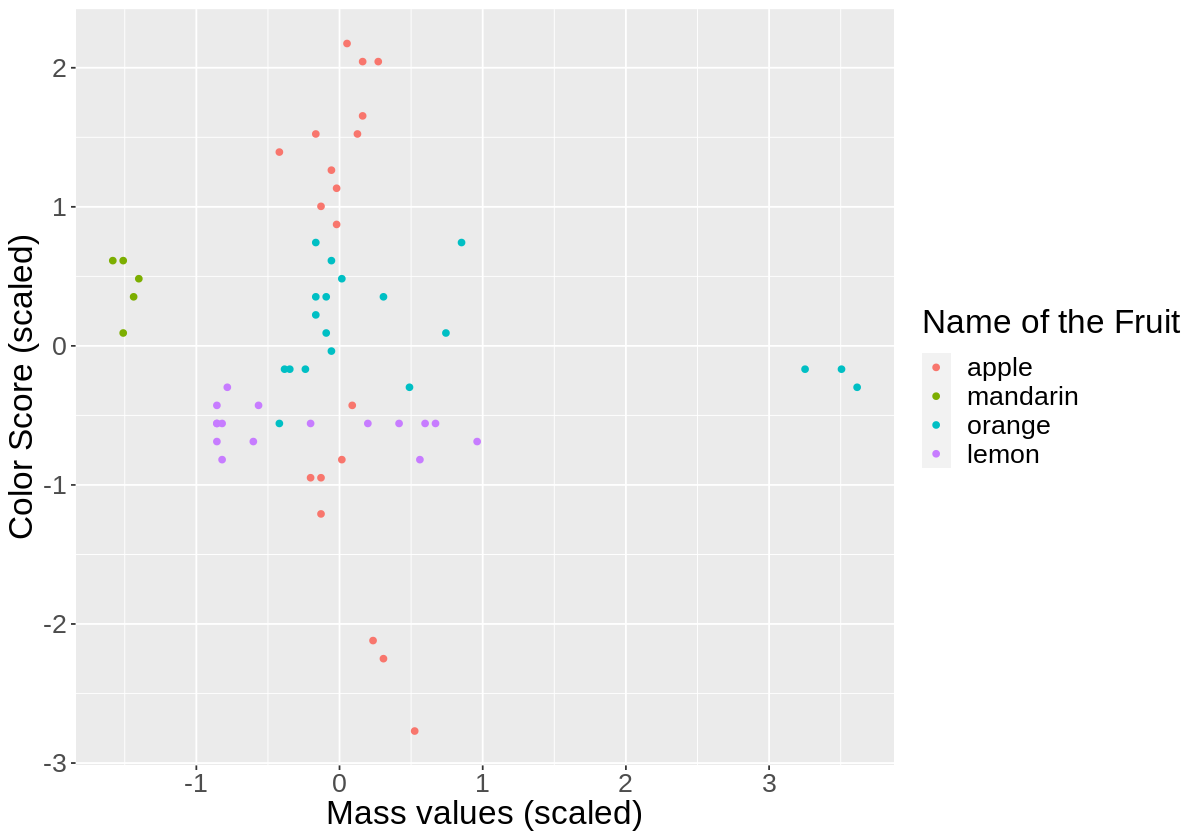

In [23]:
# your code here
fruit_plot <- ggplot(fruit_data_scaled, aes(x = mass, y = color_score, color = fruit_name))+
            geom_point()+
            labs(x = "Mass values (scaled)", y = "Color Score (scaled)", color = "Name of the Fruit")+
            theme(text = element_text(size = 20))
fruit_plot

In [24]:
test_1.7()

[1] "Success!"


**Question 1.8** 
<br> {points: 3}

Suppose we have a new observation in the fruit dataset with scaled mass 0.5 and scaled color score 0.5.

Just by looking at the scatterplot, how would you classify this observation using K-nearest neighbours if you use K = 3? Explain how you arrived at your answer.

By looking at the plot above, we can say that an observation with scaled mass 0.5 and scaled color score 0.5 is in the range where the oranges are mostly located. By using the K=3 classification, I can see that the closest 3 points to our new observation are all oranges, therefore, this observation should also be classified as an orange. 

**Question 1.9**
<br> {points: 1}

Now, let's use the `tidymodels` package to predict `fruit_name` for another new observation. The new observation we are interested in has mass 150g and color score 0.73.

First, create the K-nearest neighbour model specification. Specify we want $K=5$ neighbors, `set_engine` to be `"kknn"`, and we want to use the *straight-line distance*. Name this model specification as `knn_spec`.

Then create a new recipe named `fruit_data_recipe_2` that centers and scales the predictors, but only uses `mass` and `color_score` as predictors.

Combine this with your recipe from before in a `workflow`, and fit to the `fruit_data` dataset. 

Name the fitted model `fruit_fit`.

In [25]:
# Set the seed. Don't remove this!
set.seed(9999) 

#... <- nearest_neighbor(weight_func = ..., neighbors = ...) %>%
#       ...(...) %>%
#       ...(...)

#... <- recipe(... ~ ... + ..., data = fruit_data) %>%
#                        ...(...) %>%
#                        ...(...)

#... <- ...() %>%
#          ...(...) %>%
#          ...(...) %>%
#          fit(data = ...)


# your code here
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) %>%
      set_engine("kknn") %>%
      set_mode("classification")

fruit_data_recipe_2 <- recipe(fruit_name ~ mass + color_score, data = fruit_data) %>%
                       step_scale(all_predictors()) %>%
                       step_center(all_predictors())

fruit_fit <- workflow() %>%
         add_recipe(fruit_data_recipe_2) %>%
         add_model(knn_spec) %>%
         fit(data = fruit_data)
fruit_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~5, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1016949
Best kernel: rectangular
Best k: 5

In [26]:
test_1.9()

[1] "Success!"


**Question 1.10**
<br> {points: 1}

Create a new tibble where `mass = 150` and `color_score = 0.73` and call it `new_fruit`. Then, pass `fruit_fit` and `new_fruit` to the `predict` function to predict the class for the new fruit observation. Save your prediction to an object named `fruit_predicted`.

In [27]:
# your code here
new_fruit = tibble(mass = 150, color_score = 0.73)#where is the scaled versions? do we give the unscaled #s, it predicts?
fruit_predicted <- predict(fruit_fit, new_fruit)
fruit_predicted

.pred_class
<fct>
orange


In [28]:
test_1.10()

[1] "Success!"


**Question 1.11** 
<br> {points: 3}

Revisiting `fruit_plot` and considering the prediction given by K-nearest neighbours above, do you think the classification model did a "good" job predicting? Could you have done/do better? Given what we know this far in the course, what might we want to do to help with tricky prediction cases such as this?

*You can use the code below to visualize the observation whose label we just tried to predict.*

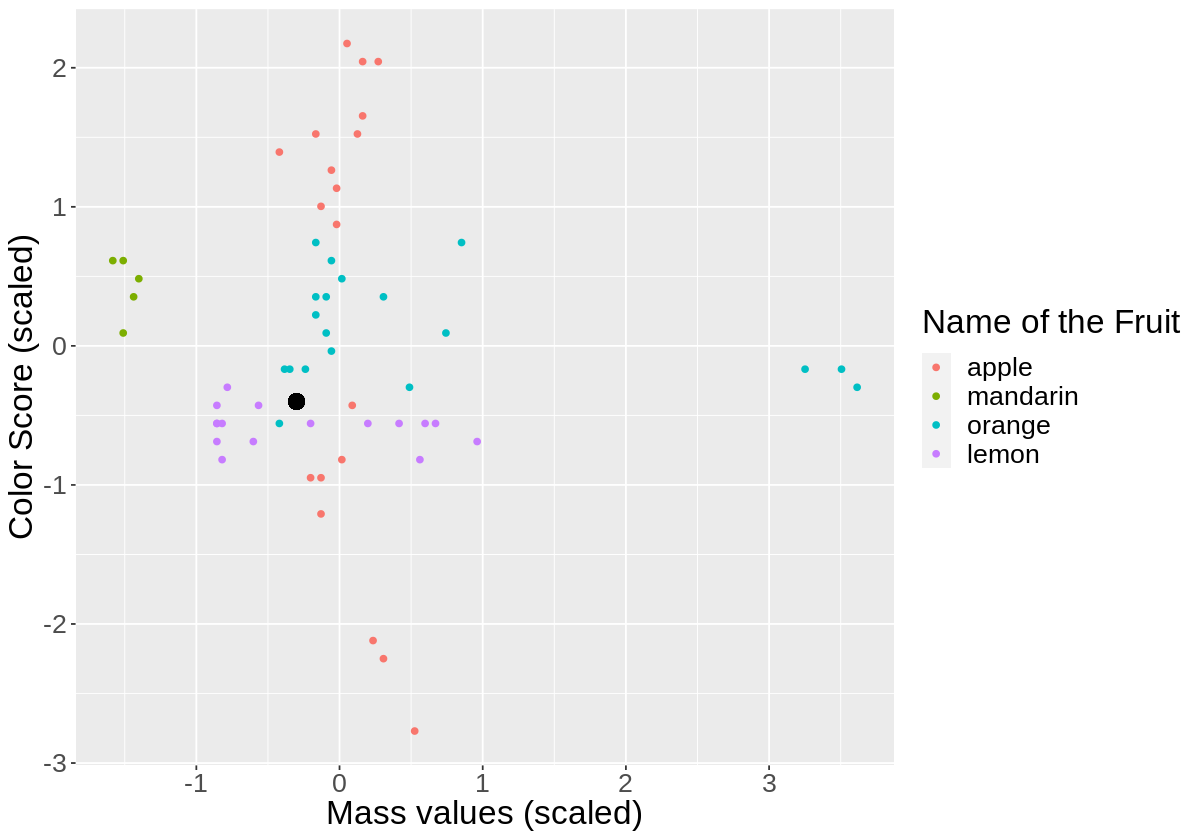

In [29]:
options(repr.plot.width = 10, repr.plot.height = 7) # you can change the plot size 

fruit_plot + 
    geom_point(aes(x = -0.3, y = -0.4), color = "black", size = 4)

I think looking at the plot above it seems like the model did an okay job of predicting that the new observation is an orange, because we see that this is a case where we can't always see the result very easily, as there are also some lemon observations nearby, and it was at a point where it is close to the boundary. So, I think the model helped us decide whether this observation could be an orange or a lemon with K=5. What we could have done to make the prediction better could have been checking the fruit_fit to see whether we can change the K to something else to improve our prediction, but it looks like the best K value was 5 along with best kernel of rectangular. So it seems we have selected the best options for this situation, and in some tricky cases as this, we should try to see what R shows us as the best K value, and maybe play with that K value. 

We can also think about the other variables and attributes of this observation, not just these mass values and color scores. These extra attributes and variables such as height or width could help us identify whether it is an orange or a lemon, or more specifically some of the variables that are different between lemons and oranges, so that we can see more clearly whether this observation is one or the other. This way we could improve our predictions for tricky cases.  

**Question 1.12**
<br> {points: 1}

Now do K-nearest neighbours classification again with the same data set, same K, and same new observation. However, this time, let's use **all the columns in the dataset as predictors (except for the categorical `fruit_label` and `fruit_subtype` variables).**

We have provided the `new_fruit_all` dataframe below, which encodes the predictors for our new observation. Your job is to use K-nearest neighbours to predict the class of this point. You can reuse the model specification you created earlier. 

*Assign your answer (the output of `predict`) to an object called `fruit_all_predicted`.*

In [30]:
#This is the new observation to predict class label for
new_fruit_all <- tibble(mass = 150, 
                            color_score = 0.73, 
                            height = 10,
                            width = 6)


# no hints this time!

# your code here
fruit_data_df <- select(fruit_data, -fruit_label, -fruit_subtype)
fruit_data_df

fruit_data_recipe_3 <- recipe(fruit_name ~., data = fruit_data_df) %>%
                       step_scale(all_predictors()) %>%
                       step_center(all_predictors())

fruit_fit_2 <- workflow() %>%
         add_recipe(fruit_data_recipe_3) %>%
         add_model(knn_spec) %>%
         fit(data = fruit_data_df)
#fruit_fit_2

fruit_all_predicted <- predict(fruit_fit_2, new_fruit_all)
fruit_all_predicted

fruit_name,mass,width,height,color_score
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
apple,192,8.4,7.3,0.55
apple,180,8.0,6.8,0.59
apple,176,7.4,7.2,0.60
⋮,⋮,⋮,⋮,⋮
lemon,116,5.9,8.1,0.73
lemon,152,6.5,8.5,0.72
lemon,118,6.1,8.1,0.70


.pred_class
<fct>
lemon


In [31]:
test_1.12()

[1] "Success!"


**Question 1.13** 
<br> {points: 3}

Did your second classification on the same data set with the same K change the prediction? If so, why do you think this happened?

Yes, the second classification on the same data set with same K changed the prediction, we got a result of lemon for this observation, because we used all the columns in the dataset as predictors (except for the categorical fruit_label and fruit_subtype variables). This clearly results in a different algortihm/prediction than the first time we only used the mass and color_score, in the second time we used all of these columns as contributors to the prediction.  

We have also accounted for the other variables such as width and height that helped us see this observation fits the profile of lemons more than oranges. Because we know that lemons and oranges have different widths and heights, whereas their colors could be similar as orange and yellow. Thus, using these extra information helped us differentiate between the orange and lemon cases. So, this is why the prediction has changed.

## 2. Wheat Seed Dataset

X-ray images can be used to analyze and sort seeds. In [this data set](https://archive.ics.uci.edu/ml/datasets/seeds), we have 7 measurements from x-ray images from 3 varieties of wheat seeds (Kama, Rosa and Canadian). 

**Question 2.0**
<br> {points: 3}

Let's use `tidymodels` to perform K-nearest neighbours to classify the wheat variety of seeds. The data set is available here: https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt. **Download the data set directly from this URL using the `read_table2()` function**, which is helpful when the columns are separated by one or more white spaces.

The seven measurements were taken below for each wheat kernel:
1. area A, 
2. perimeter P, 
3. compactness C = 4*pi*A/P^2, 
4. length of kernel, 
5. width of kernel, 
6. asymmetry coefficient 
7. length of kernel groove. 

The last column in the data set is the variety label. The mapping for the numbers to varieties is listed below:

- 1 == Kama
- 2 == Rosa
- 3 == Canadian

Use `tidymodels` with this data to perform K-nearest neighbours to classify the wheat variety of a new seed we measure with the given observed measurements (from an x-ray image) listed above. Specify that we want $K = 5$ neighbors to perform the classification. Don't forget to perform any necessary preprocessing!

*Assign your answer to an object called `seed_predict`.*

Hints: 
- `colnames()` can be used to specify the column names of a data frame.
- the wheat variety column appears numerical, but you want it to be treated as categorical for this analysis, thus `as_factor()` might be helpful.

In [32]:
# Set the seed. Don't remove this!
set.seed(9999) 

#This is the new observation to predict
new_seed <- tibble(area = 12.1,
                        perimeter = 14.2,
                        compactness = 0.9,
                        length = 4.9,
                        width = 2.8,
                        asymmetry_coefficient = 3.0, 
                        groove_length = 5.1)

# your code here
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt"
download.file(url, destfile = "data/seeds_dataset.txt")
#?read_table2()
test <- c("area", "perimeter", "compactness", "length", "width", "asymmetry_coefficient", "groove_length", "variety")
df <- read_table2("data/seeds_dataset.txt", col_names = test)
#df 
#test <- c(area, perimeter, compactness, length, width, asymmetry_coefficient, groove_length, variety)
#df <- rename(df, test = colnames(df)) #throws error here 
# df <- rename(df, area = X1, perimeter = X2, compactness = X3, 
#              length = X4, width = X5, 
#              asymmetry_coefficient = X6, groove_length = X7, variety = X8)
df <- mutate(df, variety = as_factor(variety)) # make it a factor here
df

# here knn specificatios
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) %>%
      set_engine("kknn") %>%
      set_mode("classification")

# here recipe and then get scaled data frame
data_recipe <- recipe(variety ~., data = df) %>%
                       step_scale(all_predictors()) %>%
                       step_center(all_predictors())

seed_fit <- workflow() %>%
         add_recipe(data_recipe) %>%
         add_model(knn_spec) %>%
         fit(data = df)
#seed_fit

seed_predict <- predict(seed_fit, new_seed)
seed_predict

Parsed with column specification:
cols(
  area = col_double(),
  perimeter = col_double(),
  compactness = col_double(),
  length = col_double(),
  width = col_double(),
  asymmetry_coefficient = col_double(),
  groove_length = col_double(),
  variety = col_double()
)



area,perimeter,compactness,length,width,asymmetry_coefficient,groove_length,variety
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
13.20,13.66,0.8883,5.236,3.232,8.315,5.056,3
11.84,13.21,0.8521,5.175,2.836,3.598,5.044,3
12.30,13.34,0.8684,5.243,2.974,5.637,5.063,3


.pred_class
<fct>
3


**Question 2.1** Multiple Choice:
<br> {points: 1}

What is classification of the `new_seed` observation?

A. Kama

B. Rosa

C. Canadian

*Assign your answer to an object called `answer2.1`. Make sure your answer is in uppercase and is surrounded by quotation marks (e.g. `"F"`).*


In [33]:
# your code here
answer2.1 <- "C"

In [34]:
test_2.1()

[1] "Success!"


In [35]:
source("cleanup_tutorial_06.R")